### In this notebook we explore the data lightly and create some preliminary plots

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import collections
import os

processed_folder_path = os.path.join("..", "data", "processed")
unprocessed_folder_path = os.path.join("..", "data", "unprocessed")

## Plot data density

### NDSI and NDVI data density given time

In [2]:
df_NDSI = pd.read_csv(os.path.join(processed_folder_path, "NDSI.csv"), index_col=0)
df_NDVI = pd.read_csv(os.path.join(processed_folder_path, "NDSI.csv"), index_col=0)

In [3]:
def plot_data_density(dfs, labels):
    plt.figure(figsize=(14, 8))
    for df, label in zip(dfs, labels):
        plt.plot(df.groupby(["year"]).size(), label=label)
    
    plt.title("Frequency of years in data")
    plt.xlabel("Year")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    for df, label in zip(dfs, labels):
        plt.plot(df.groupby(["month"]).size(), label=label)

    plt.xticks(range(12), range(1, 13))
    plt.title("Frequency of months in data")
    plt.xlabel("Month")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

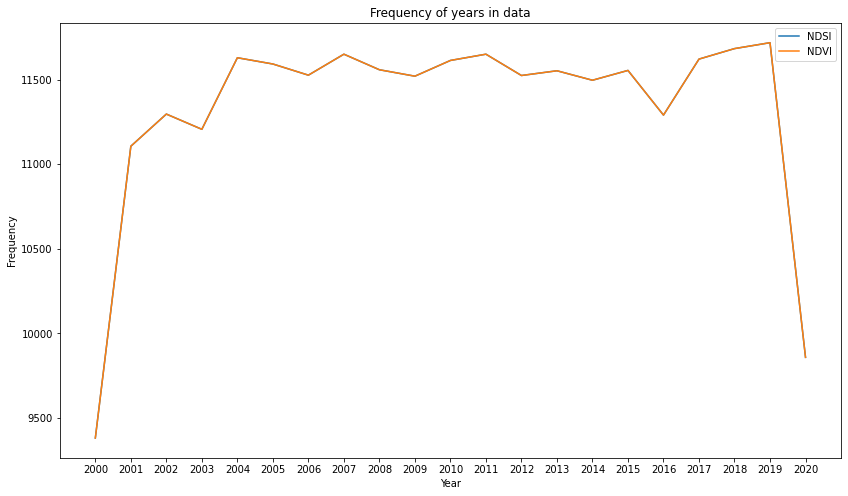

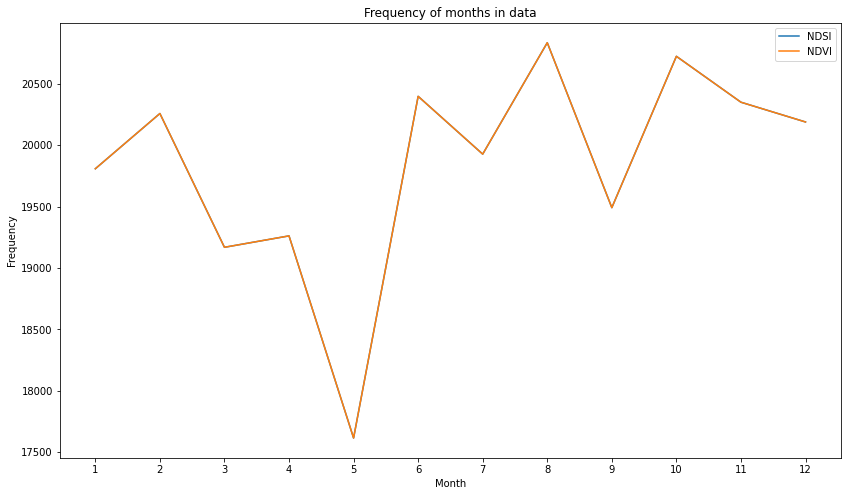

In [4]:
df_NDSI["Date"] = pd.to_datetime(df_NDSI["Date"])
df_NDSI["year"] = df_NDSI["Date"].apply(lambda x: "%d" % (x.year))
df_NDSI["month"] = df_NDSI["Date"].apply(lambda x: "%d" % (x.month)) 

df_NDVI["Date"] = pd.to_datetime(df_NDVI["Date"])
df_NDVI["year"] = df_NDSI["Date"].apply(lambda x: "%d" % (x.year))
df_NDVI["month"] = df_NDSI["Date"].apply(lambda x: "%d" % (x.month)) 

plot_data_density([df_NDSI, df_NDVI], ["NDSI", "NDVI"])

## River Flow Data
### Data Density

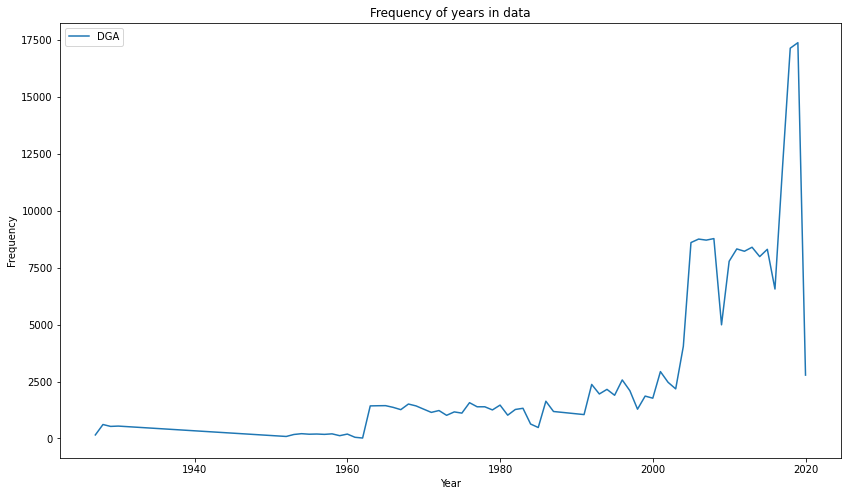

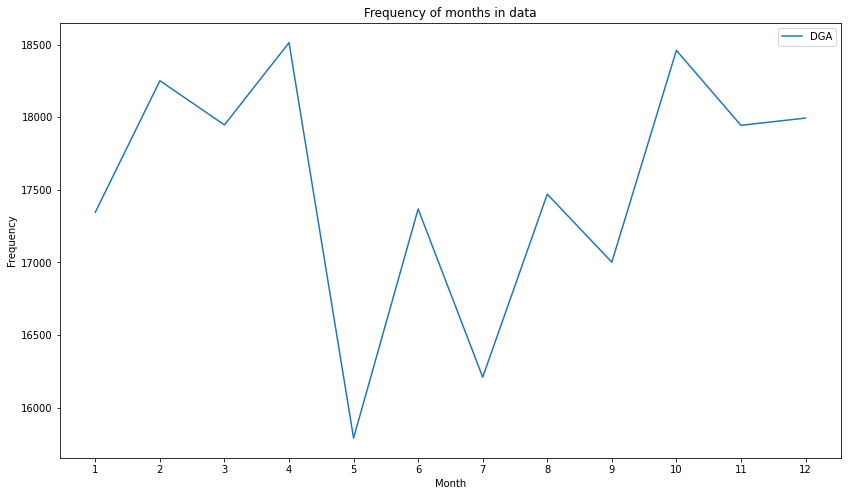

In [5]:
df_DGA = pd.read_csv(os.path.join(processed_folder_path, "DGA.csv"), index_col=0)

df_DGA["date"] = pd.to_datetime(df_DGA["date"])

df_DGA["year"] = df_DGA["date"].apply(lambda x: "%d" % (x.year))
df_DGA["month"] = df_DGA["date"].apply(lambda x: "%d" % (x.month)) 

df_DGA["year"] = df_DGA["year"].astype(int)

plot_data_density([df_DGA], ["DGA"])

### Monthly Flow Data

<AxesSubplot:title={'center':'Wet Years'}, xlabel='Water Year', ylabel='Discharge (cubic feet / sec)'>

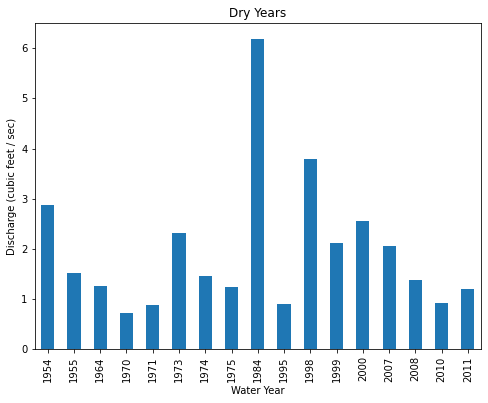

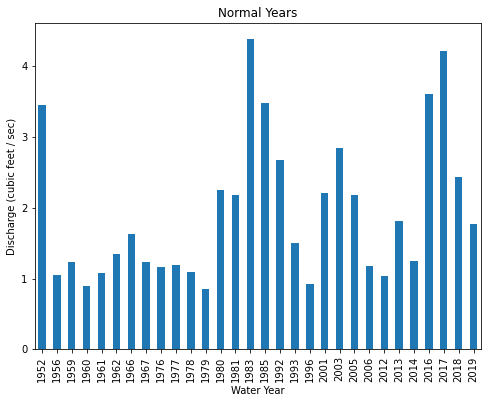

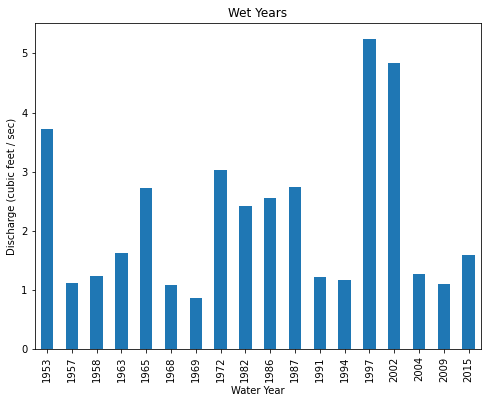

In [6]:
dry_discharge_rate = df_DGA.loc[df_DGA["year_type"] == -1].groupby("water_year")[["river_flow"]].mean()
dry_discharge_rate.plot.bar(figsize=(8, 6), title="Dry Years", xlabel='Water Year', ylabel='Discharge (cubic feet / sec)', legend=False)

normal_discharge_rate = df_DGA.loc[df_DGA["year_type"] == 0].groupby("water_year")[["river_flow"]].mean()
normal_discharge_rate.plot.bar(figsize=(8, 6), title="Normal Years", xlabel='Water Year', ylabel='Discharge (cubic feet / sec)', legend=False)

wet_discharge_rate = df_DGA.loc[df_DGA["year_type"] == 1].groupby("water_year")[["river_flow"]].mean()
wet_discharge_rate.plot.bar(figsize=(8, 6), title="Wet Years", xlabel='Water Year', ylabel='Discharge (cubic feet / sec)', legend=False)